# Vehicle Tracking Project

### Load the Vehicle Files

In [1]:
import glob
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
DEBUG_PLOTS = True

import warnings
warnings.filterwarnings('ignore')


car_files = glob.glob('./vehicles/*/*.png')
noncar_files = glob.glob('./non-vehicles/*/*.png')

print("Vehicles:     {}".format(len(car_files)))
print("Non-vehicles: {}".format(len(noncar_files)))

Vehicles:     8792
Non-vehicles: 8968


### Utilities

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
# Use cv2.resize().ravel() to create the feature vector
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features


def convert_color(img, conv='RGB'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return np.copy(img)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature_image = convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image

    return img

### Extract Features

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = False  # Spatial features on or off
hist_feat = False  # Histogram features on or off
hog_feat = True  # HOG features on or off


car_features = extract_features(car_files, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

noncar_features = extract_features(noncar_files, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Features and labels
X = np.vstack((car_features, noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 1188


### Train Support Vector Machine Classifier (SVM)

In [73]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import time

clf = LinearSVC()

# Check the training time for the SVC
t = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

0.82 Seconds to train SVC...
Test Accuracy of SVC =  0.9862


### Find Cars

In [74]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
#  - cell_per_block

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            test_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                box_top_left = (xbox_left, ytop_draw + ystart)
                box_bottom_right = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                
                boxes.append((box_top_left, box_bottom_right))
                
    return boxes


### Pipeline

In [131]:
regions = [(400, 528), (400, 592), (384, 656), (368, 656), (376, 656), (384, 656)]
scales = [1.5, 1.75, 2, 2.5, 2.5, 2]

# regions = [(384, 656)]
# scales = [2]

X_scaler = []

def pipeline(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    global prev_bboxes
    
    bboxes = []
    for idx, scale in enumerate(scales):
        ystart, ystop = regions[idx] #(360, 670)
        boxes = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, 
                          pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes = bboxes + boxes
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, bboxes + prev_bboxes)

    # Apply threshold to help remove false positives

    heat = apply_threshold(heat, 1 + len(prev_bboxes) // 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    label_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,16))
    f.subplots_adjust(hspace = .1, wspace=.1)
    
    prev_bboxes = bboxes
    
    if DEBUG_PLOTS:
        ax1.axis('off')
        ax1.imshow(img)

        window_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
        ax2.axis('off')
        ax2.imshow(window_img)

        ax3.axis('off')
        ax3.imshow(heatmap, cmap='gray')

        ax4.axis('off')
        ax4.imshow(label_img)

        plt.show()
        
    return label_img

### Run on Test Images

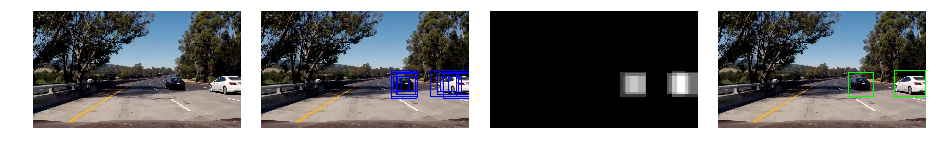

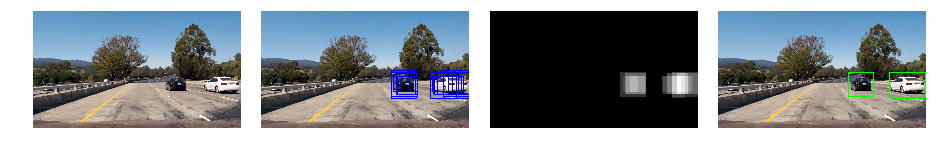

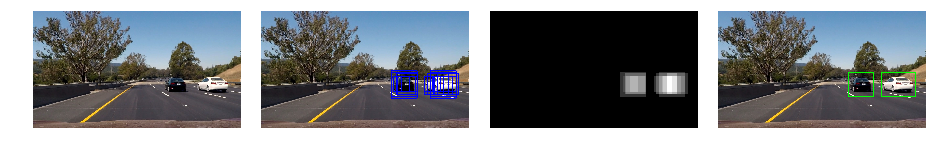

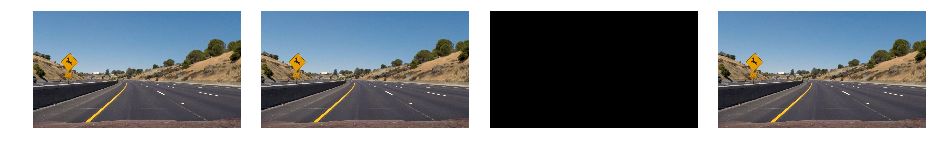

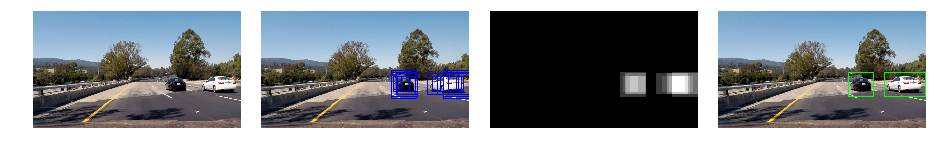

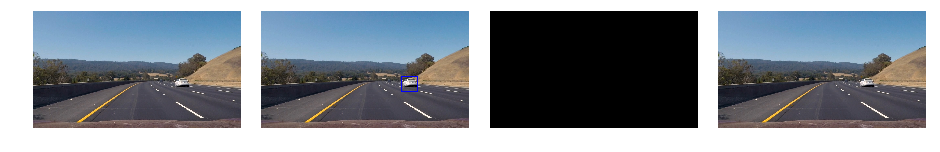

In [132]:
DEBUG_PLOTS = True

for path in glob.glob('./test_images/test*.jpg'):
    prev_bboxes = []
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    output = pipeline(img)


### Visualize HOG Results

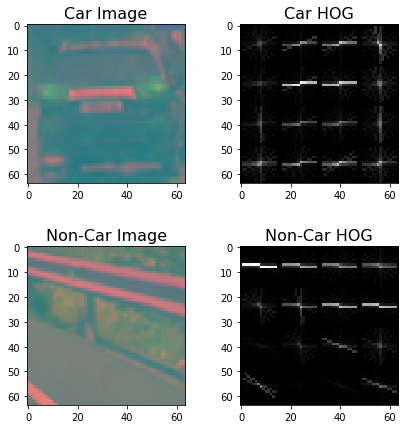

In [138]:
car_img = cv2.imread(car_files[150])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
car_img = convert_color(car_img, 'YCrCb')
_, car_dst = get_hog_features(car_img[:,:,0], 11, 16, 2, vis=True, feature_vec=True)
noncar_img = cv2.imread(noncar_files[1500])
noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)
noncar_img = convert_color(noncar_img, 'YCrCb')
_, noncar_dst = get_hog_features(noncar_img[:,:,0], 11, 16, 2, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.show()


### Run on Test Video

In [133]:
from moviepy.editor import VideoFileClip

DEBUG_PLOTS = False
prev_bboxes = []

test_output = './output_videos/test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")

test_output_clip = clip1.fl_image(pipeline)
%time test_output_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 

CPU times: user 1min 22s, sys: 132 ms, total: 1min 23s
Wall time: 21.7 s


In [134]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [139]:
from moviepy.editor import VideoFileClip

DEBUG_PLOTS = False

project_output = './output_videos/project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4")
# clip1 = VideoFileClip("./project_video.mp4")
# clip1 = VideoFileClip("./project_video.mp4")

output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [11:29<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 47min 1s, sys: 6.01 s, total: 47min 7s
Wall time: 11min 29s


In [140]:
from IPython.display import HTML


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))